In [2]:
import pandas as pd
import numpy as np
from cherenkovdeconvolution import util
from mord import LogisticAT
from cherenkovdeconvolution import dsea
from sklearn.linear_model import LogisticRegression
from mord import LogisticSE
from sklearn.tree import ExtraTreeClassifier
from matplotlib import pyplot as plt
from sklearn.preprocessing import power_transform
import cherenkovdeconvolution.stepsize as stepsize

#p.set_printoptions(threshold=np.inf)
#df = pd.read_csv('sample.csv')
df=pd.read_csv('sample.csv', nrows=500000)
#print(df.head(8))
#X = df[['SplineMPEDirectHitsD.dir_track_length',
#'SPEFit2_HVFitParams.nmini'                       ,
#'LineFitGeoSplit2.zenith',
#   'SplineMPE.zenith'    ,
#     'SplineMPE.azimuth' 
#       'SPEFit2GeoSplit1BayesianFitParams.nmini',
#       'SPEFit2Bayesian.x',
#       'VariousVariables.Cone_Angle',
#       'SPEFit2TimeSplit1FitParams.logl',
#       'weight_honda_h4a']]
X = df[['SPEFit2Bayesian.x',
        'SPEFit2BayesianFitParams.nmini',
        'SPEFit2_HVFitParams.nmini',
        'SplineMPE.zenith',
        'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom',
        'SplineMPEDirectHitsD.dir_track_length',
        'SplineMPEDirectHitsICB.n_early_strings',
        'SplineMPEDirectHitsICB.n_late_doms',
        'SplineMPEDirectHitsICD.n_dir_strings',
        'SplineMPEDirectHitsICE.n_late_strings',
        'SplineMPETruncatedEnergy_SPICEMie_AllDOMS_MuEres.value',
        'weight_honda_h4a',
        'LineFitGeoSplit2.zenith',
        'VariousVariables.Cone_Angle',
        'SPEFit2GeoSplit1BayesianFitParams.nmini',
        'SPEFit2TimeSplit1FitParams.logl']]

Y = df['MCPrimary.energy']
#'Dustyness.n_doms_in_dust','BestTrackDirectHitsICC.n_early_strings',
binning_E = np.logspace(np.log10(Y.min()-10),
np.log10(Y.max()+100), 13)    # creating 12 bins for the energy 



#Binning overflow & underflow manually
overflow = 1e10
bins_over = np.append(binning_E,overflow)
binning_E = bins_over

Y = np.digitize(Y, binning_E)  

Y = Y - 1

n_test = int(len(df)/10)

X_train = X.iloc[n_test:]#splitting the dataframe
Y_train = Y[n_test:]

X_test = X.iloc[:n_test]
Y_test = Y[:n_test]

f_true = util.fit_pdf(Y_test) 
f_true


array([2.5592e-01, 3.6756e-01, 2.1952e-01, 9.6880e-02, 3.8640e-02,
       1.4100e-02, 4.6800e-03, 1.6600e-03, 6.8000e-04, 2.4000e-04,
       8.0000e-05, 4.0000e-05])

In [38]:


f_ord=dsea(X_test, X_train, Y_train,LogisticSE(alpha=1.), K = 3)
f_ord

array([3.22372830e-03, 5.40486074e-02, 2.89053493e-01, 4.10241902e-01,
       1.85492345e-01, 4.69863009e-02, 8.98352266e-03, 1.68675278e-03,
       2.02501171e-04, 5.75669401e-05, 2.23612490e-05, 9.18274402e-07])

In [39]:


f_multi = dsea(X_test, X_train, Y_train,LogisticRegression(multi_class='multinomial',max_iter=100000), K=3)#doesnt work with the default solver?

/home/jajaek/.local/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jajaek/.local/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [40]:


f_multi2 = dsea(X_test, X_train, Y_train,LogisticRegression(solver='saga',multi_class='multinomial',max_iter=10000), K=3)
f_multi2

array([0.04861655, 0.0698211 , 0.08373528, 0.09095279, 0.09557769,
       0.0964889 , 0.09670598, 0.09351049, 0.08799714, 0.07809829,
       0.08581873, 0.07267705])

In [41]:


f_extra = dsea(X_test, X_train, Y_train, ExtraTreeClassifier(), K=3) 

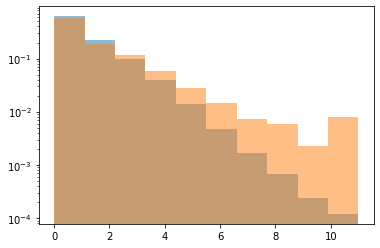

In [43]:
#plotting Multinomial Logistic Regression against f_true

plt.hist(range(12), weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(range(12), weights = f_multi, alpha = 0.5,label='f_multi')
plt.yscale('log')
plt.show()

In [1]:
#plotting Multinomial Logistic Regression with the saga solver against f_true
plt.hist(range(12), weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(range(12), weights = f_multi2, alpha = 0.5,label='f_saga')
plt.yscale('log')
plt.show()

NameError: name 'plt' is not defined

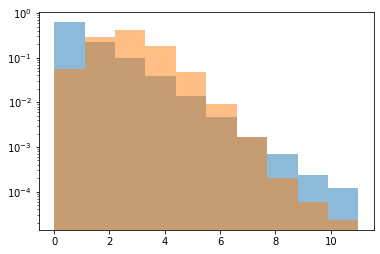

In [45]:
#plotting LogisticSE against f_true
plt.hist(range(12), weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(range(12), weights = f_ord, alpha = 0.5,label='f_ord')
plt.yscale('log')
plt.show()

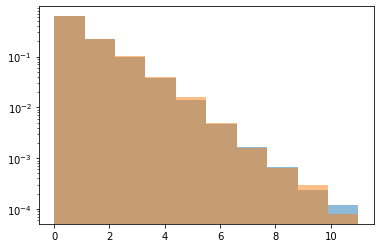

In [46]:
#plotting Extra Tree Classifier against f_true
plt.hist(range(12), weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(range(12), weights = f_extra, alpha = 0.5,label='f_extra')
plt.yscale('log')
plt.show()

In [4]:
#run dsea(LogisticSE) with boxcox transformed data
#from scipy import stats
#from scipy.special import boxcox1p


#transforming training and test data, while not transforming the target
#X_box[0]=stats.boxcox(df['SPEFit2Bayesian.x']) boxcox needs strictly positive data maybe yeo-johnson transform ist better suited
X_box= power_transform(X, method='yeo-johnson')    
X_btrain = X_box[n_test:]#splitting the dataframe
X_btest = X_box[:n_test]



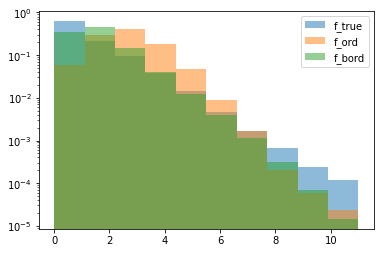

In [9]:
f_ord=([3.22372830e-03, 5.40486074e-02, 2.89053493e-01, 4.10241902e-01,
       1.85492345e-01, 4.69863009e-02, 8.98352266e-03, 1.68675278e-03,
       2.02501171e-04, 5.75669401e-05, 2.23612490e-05, 9.18274402e-07])

f_bord=dsea(X_btest, X_btrain, Y_train,LogisticSE(alpha=1.), K = 3)

plt.hist(range(12), weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(range(12), weights = f_ord, alpha = 0.5,label='f_ord')
plt.hist(range(12), weights = f_bord, alpha = 0.5,label='f_bord')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [ ]:
#from mord import LogisticAT
f_AT=dsea(X_btest, X_btrain, Y_train,LogisticAT(alpha=1.), K = 3)

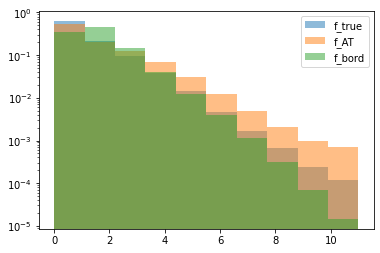

In [ ]:
plt.hist(range(12), weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(range(12), weights = f_AT, alpha = 0.5,label='f_AT')
plt.hist(range(12), weights = f_bord, alpha = 0.5,label='f_bord')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

0
1
2
3


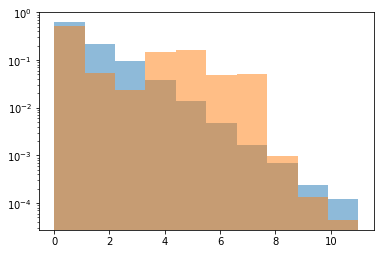

In [5]:
#logistic AT with decaying stepsize(unstransformed data)
def inspect_alpha(k, alpha, chi2s, f): # you can define custom inspection methods to investigate DSEA
    print(alpha)

# There are two decay rates, the first of which is comparably slow
alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul = dsea(X_test, X_train, Y_train, LogisticAT(alpha=1.), K = 3, inspect = inspect_alpha, alpha = alpha_mul)
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_AT_mul, alpha = 0.5)
plt.yscale('log')
plt.show()

0
1
2
3
4
5


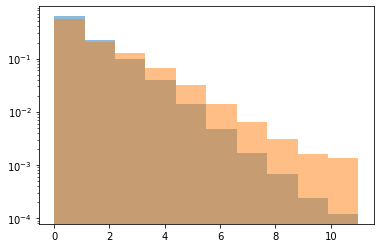

In [17]:
#logistic AT with decaying stepsize(transformed data)
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul = dsea(X_btest, X_btrain, Y_train, LogisticAT(), K = 5, inspect = inspect_alpha, alpha = alpha_mul)
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_AT_mul, alpha = 0.5)
plt.yscale('log')
plt.show()

0
1
2
3
4
5


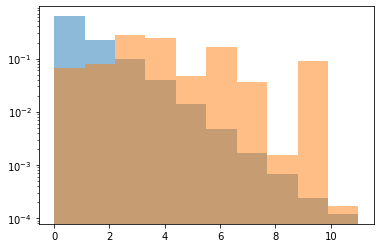

In [18]:
#logistic AT with exponential decaying stepsize(transformed data)
alpha_exp = stepsize.decay_exp(0.5, 2.0)
f_AT_exp = dsea(X_test, X_train, Y_train, LogisticAT(), K = 5, inspect = inspect_alpha,  alpha = alpha_exp)
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_AT_exp, alpha = 0.5)
plt.yscale('log')
plt.show()

In [26]:
#feature selection on logisticAT
from sklearn.feature_selection import RFE
estimator= LogisticAT()
selector = RFE(estimator, n_features_to_select=10, step=1)
selector.fit(X_box,Y)
selector.ranking_

array([6, 3, 4, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 8, 7, 2, 1])

In [27]:
#just keeping the best ranked features
X_RFE=selector.transform(X_box)
X_rfetrain = X_RFE[n_test:]#splitting the dataframe
X_rfetest = X_RFE[:n_test]


0
1
2
3
4
5


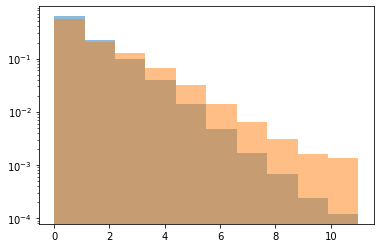

In [29]:
#logisticAT on the best features with decaying stepsize
def inspect_alpha(k, alpha, chi2s, f):
    print(alpha)


alpha_mul = stepsize.decay_mul(0.5)
f_AT_mul = dsea(X_rfetest, X_rfetrain, Y_train, LogisticAT(), K = 5, inspect = inspect_alpha, alpha = alpha_mul)
plt.hist(range(12), weights = f_true, alpha = 0.5)
plt.hist(range(12), weights = f_AT_mul, alpha = 0.5)
plt.yscale('log')
plt.show()

In [ ]:
#passive aggressive regression(well fitted for large scale data)
from sklearn.linear_model import PassiveAggressiveRegressor
f_par=dsea(X_test, X_train, Y_train,ARDRegression(), K = 3)
#rebinning data
binning_f = np.linspace(0,12, 13)
overflow = 1e10
bins_over = np.append(binning_f,overflow)
bins_over = np.append(binning_f,overflow)
binning_f = bins_over
f_par = np.digitize(f_par, binning_f)  

f_par = f_par - 1
f_par = util.fit_pdf(f_par) # not sure about that part but through the rebinning I should be left with filled bins and not the pdf 
plt.hist(range(12), weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(range(12), weights = f_par, alpha = 0.5,label ='f_par')
plt.yscale('log')
plt.show()

In [13]:
#implement classic linear regression
from sklearn.linear_model import LinearRegression


f_lin=dsea(X_test, X_train, Y_train,LinearRegression(), K = 3)
#rebinning data
binning_f = np.linspace(0,12, 13)
overflow = 1e10
bins_over = np.append(binning_f,overflow)
bins_over = np.append(binning_f,overflow)
binning_f = bins_over
f_lin = np.digitize(f_lin, binning_f)  

f_lin = f_lin - 1
f_lin = util.fit_pdf(f_lin) # not sure about that part but through the rebinning I should be left with filled bins and not the pdf 

plt.hist(range(12), weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(range(12), weights = f_lin, alpha = 0.5,label ='f_lin')
plt.yscale('log')
plt.show()

AttributeError: 'LinearRegression' object has no attribute 'predict_proba'

In [ ]:
#ARD regression
from sklearn.linear_model import ARDRegression
f_ARD=dsea(X_test, X_train, Y_train,ARDRegression(), K = 3)
#rebinning data
binning_f = np.linspace(0,12, 13)
overflow = 1e10
bins_over = np.append(binning_f,overflow)
bins_over = np.append(binning_f,overflow)
binning_f = bins_over
f_ARD = np.digitize(f_ARD, binning_f)  

f_ARD = f_ARD - 1
f_ARD = util.fit_pdf(f_ARD) # not sure about that part but through the rebinning I should be left with filled bins and not the pdf 
plt.hist(range(12), weights = f_true, alpha = 0.5,label ='f_true')
plt.hist(range(12), weights = f_ARD, alpha = 0.5,label ='f_ARD')
plt.yscale('log')
plt.show()